In [142]:
# https://course.fast.ai/videos/?lesson=6

## Multi label clas

In [2]:
import fastbook
fastbook.setup_book()

In [114]:
from fastbook import *
from fastai.vision.widgets import *

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Download Dataset

In [4]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [8]:
os.listdir(path)

['segmentation',
 'test',
 'test.csv',
 'test.json',
 'train',
 'train.csv',
 'train.json',
 'valid.json']

In [6]:
# create a dataframe
df = pd.read_csv(path/'train.csv')

In [9]:
# view first 10 rows
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### DataBlock and Dataloaders

In [25]:
# dbblock = DataBlock(blocks = (<inputblock>, <outputblock>), get_x = <func>, get_y = <func>)

>fname  - x

>labels - y

In [60]:
Path.BASE_PATH = path

def get_x(row):
    # return path for the image
    return path/'train'/row['fname']

def get_y(row):
    # return labels as a list
    return row['labels'].split(' ')

In [61]:
len(df.index[~df['is_valid']].tolist()), len(df.index[df['is_valid']].tolist())

(2501, 2510)

In [62]:
def splitter(df):
    # get the indices as a list for both train and test 
    train = df.index[~df['is_valid']].tolist()
    test  = df.index[df['is_valid']].tolist()
    
    return train, test

For **Input**, we can use ImageBlock which contains all transform functions
For **Target**, we will be using multilabel category, since there are more than one labels possible

In [80]:
dbblock = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    splitter = splitter,
    get_x = get_x , 
    get_y = get_y,
    item_tfms = RandomResizedCrop(128, min_scale=0.4)
)

In [95]:
dls = dbblock.dataloaders(df, num_workers=0)

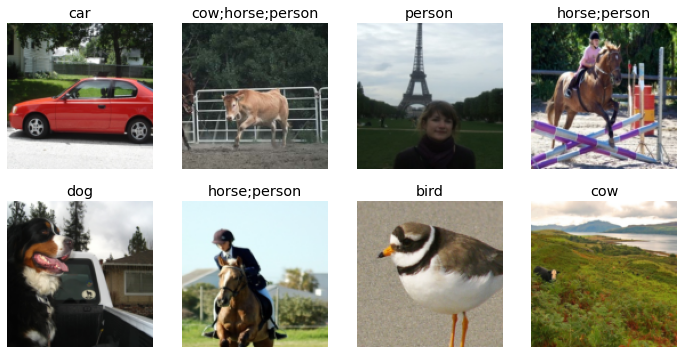

In [96]:
dls.show_batch(nrows = 2, ncols = 4)

### Learner

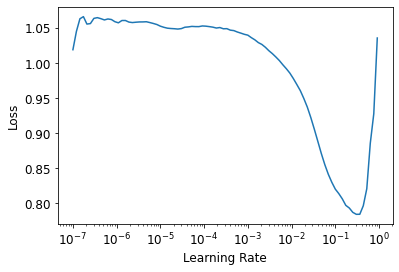

In [105]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
lr_min,lr_steep = learn.lr_find()

In [106]:
lr_min, lr_steep

(0.03019951581954956, 0.03981071710586548)

In [107]:
learn.fine_tune(3, base_lr=3e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.770975,0.400574,0.441394,03:49
1,0.391854,0.153219,0.922629,03:54
2,0.253793,0.148406,0.927311,03:48
3,0.198125,0.140993,0.929602,03:39


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.159074,0.241093,0.895617,04:50
1,0.152783,0.142988,0.932709,05:43
2,0.124859,0.126153,0.937869,04:51


## Find threshold for accuracy

In [108]:
preds, targs = learn.get_preds()

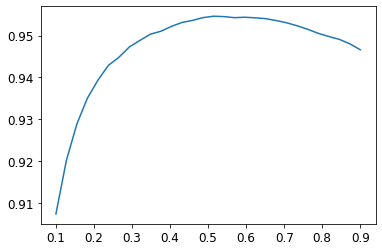

In [109]:
xs = torch.linspace(0.1, 0.9, 30)
accuracies = [ accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accuracies)

In [110]:
learn.metrics = partial(accuracy_multi, thresh=0.5)
learn.validate()

(#2) [0.12615323066711426,0.9544422626495361]

### export the model

In [112]:
learn.export()

-----------------------------------------------------------

In [115]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [119]:
img = PILImage.create(btn_upload.data[0])
predicted_labels, labels_bool, labels_probability = learn.predict(img)

In [120]:
print("labels:      ", predicted_labels)

labels:       ['bus', 'car', 'person']


In [139]:
pred_probs = labels_probability[torch.where(labels_bool == True)]

In [140]:
result = zip(predicted_labels, pred_probs.numpy())

In [141]:
for label, prob in result:
    print(label, " : ", prob, "%")

bus  :  0.99059254 %
car  :  0.60863066 %
person  :  0.52136123 %
